# 1) EDA/Cleaning of Yelp Dataset

Yelp business data is provided as 5 JSON files, each containing many dictionaries, one for each row/entry. The only dataset we used for our project is the business JSON, but the others could also be used in future additions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
yelp_df = pd.read_json("./Data/Yelp JSON/yelp_academic_dataset_business.json", lines=True)
yelp_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [ ]:
yelp_df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

Most of the dataset variables serve for identifying the business, with likely limited predictive power. To identify the geographic area of a customer base, we chose to use the city. Although this presents some challenges with city names not being strictly standardized, it provides a balance between too narrow and wide of an area. Notably, the dataset appears to use the location info entered by whoever created the Yelp page for a business, meaning that typos, incorrect addresses, and other issues are prevalent throughout the location variables.

For example, this business is in Lula Lula, Hawaii, a city that does not exist. The latitude and longitude point to a residential neighborhood in St. Louis, Missouri, which has a similarly named street called Lula Dr., but does not have the street number 1010.

In [8]:
yelp_df.loc[yelp_df["business_id"]=="bw90rjFL02A_8rVE34m5Lg"]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
12258,bw90rjFL02A_8rVE34m5Lg,Cosmetic Solutions,1010 Lula Lula Dr,Lula Lula,HI,90261,38.816486,-90.32175,3.5,17,1,"{'BusinessAcceptsCreditCards': 'False', 'Accep...","Cosmetic Surgeons, Pizza, Doctors, Beauty & Sp...",None


Since we chose to use demographic data from the U.S. Census, to avoid issues with different APIs, unit standardizations, and information availability, we chose to exclude all businesses located outside of the United States, as identified by their state(which is one of only a few unique values, likely selected from a list created by Yelp).

The states "AB", "HI", "UT", "SD", "XMS", and "VI", were excluded. "AB" is Alberta, located in Canada, "XMS" appears to be Liverpool, England, and "VI" is the (British) Virgin Islands. The others are valid American states, but only had one or two businesses, which could be manually verified to have the incorrect state. The locations(latitude/longitude) of the businesses, as visualized by *heatmap.py*, show that the dataset was likely created by selecting businesses within a certain radius of the cities 
- Santa Barbara, CA
- Reno, NV
- Tucson, AZ
- Boise, ID
- St Louis, MI
- Nashville, TN
- Indianapolis, ID
- Tampa, FL
- New Orleans, LA
- Philadelphia, PA

alongside a few others.

Since they were not particularly useful to us for demographic data identification or prediction, we dropped the columns address, postal_code, is_open, and hours. We also chose to ignore the attributes column, which had a dictionary of various things such as whether or not the business accepted credit cards, whether pets were allowed, and price level. Although this potentially could have helped differentiate otherwise similar businesses, there was a huge amount of missing data, since businesses were not required to add information, and typically only added a few attributes.

## Business Attributes

In [17]:
attribute_counts = (~pd.json_normalize(yelp_df["attributes"]).isna()).sum(axis=0).sort_values(ascending=False)
attribute_counts

BusinessAcceptsCreditCards    119765
BusinessParking                91085
RestaurantsPriceRange2         85314
BikeParking                    72638
RestaurantsTakeOut             59857
WiFi                           56914
RestaurantsDelivery            56282
GoodForKids                    53375
OutdoorSeating                 48802
RestaurantsReservations        45247
HasTV                          45084
Ambience                       44279
RestaurantsGoodForGroups       44170
Alcohol                        43189
ByAppointmentOnly              42339
Caters                         40127
RestaurantsAttire              39255
NoiseLevel                     37993
GoodForMeal                    29087
WheelchairAccessible           28953
RestaurantsTableService        19982
DogsAllowed                    18284
BusinessAcceptsBitcoin         17430
HappyHour                      15171
DriveThru                       7760
Music                           7521
AcceptsInsurance                5713
B

In [19]:
print(f"Average number of attributes per business: {(avg_attr := attribute_counts.sum()/(yelp_df.shape[0])):.2f}")
print(f"% of attribute information given: {100*avg_attr/len(attribute_counts):.2f}")

Average number of attributes per business: 8.03
% of attribute information given: 20.58


With so few attributes given, we may have had to make strong assumptions about the values of around 80% of all attribute information. Even if we excluded the attributes that only appeared a few times or indicated to the model that data was missing, there were still challenges in formatting certain attributes and streamlining new predictions(without entering information for many categories) that we decided were not worth the effort.

## Business Categories

The category column was much better normalized than attributes, being given as a string of predefined categories in no particular order, separated by ", ".

In [3]:
from collections import Counter

def categorySplit(catStr: str):
    if catStr is None:
        return ("NONE",)
    return catStr.split(", ")

category_counts = Counter(cat for catStr in yelp_df["categories"] for cat in categorySplit(catStr))
category_counts

Counter({'Restaurants': 52268,
         'Food': 27781,
         'Shopping': 24395,
         'Home Services': 14356,
         'Beauty & Spas': 14292,
         'Nightlife': 12281,
         'Health & Medical': 11890,
         'Local Services': 11198,
         'Bars': 11065,
         'Automotive': 10773,
         'Event Planning & Services': 9895,
         'Sandwiches': 8366,
         'American (Traditional)': 8139,
         'Active Life': 7687,
         'Pizza': 7093,
         'Coffee & Tea': 6703,
         'Fast Food': 6472,
         'Breakfast & Brunch': 6239,
         'American (New)': 6097,
         'Hotels & Travel': 5857,
         'Home & Garden': 5799,
         'Fashion': 5739,
         'Burgers': 5636,
         'Arts & Entertainment': 5434,
         'Auto Repair': 5433,
         'Hair Salons': 5046,
         'Nail Salons': 4621,
         'Mexican': 4600,
         'Italian': 4573,
         'Specialty Food': 4233,
         'Doctors': 3763,
         'Pets': 3758,
         'Real Estat

In [6]:
print(f"Number of categories: {len(category_counts)-1}") # -1 for NONE
print(f"Number of businesses with no category: {category_counts["NONE"]}")

Number of categories: 1311
Number of businesses with no category: 103


In [5]:
def categorySplit2(catStr: str):
    if catStr is None:
        return None
    return tuple(sorted(catStr.split(", ")))

category_count_tups = Counter(categorySplit2(catStr) for catStr in yelp_df["categories"])
len(category_count_tups)

44741

Among the just over 150,000 businesses in the dataset, there were 1,311 categories, which formed 44,741 unique pairs. e.g. (Restaurant, Chinese), and there were 103 businesses with no categories given. We considered transforming the data using one-hot encoding, with 0 if the category was not present and 1 if it was, but ultimately decided against it. Such an encoding scheme would result in an extremely sparse dataset, with 1,311 columns encoding categories but most businesses only having a few, which could hurt the performance of some models, and could also present issues if results for businesses with categories not present within those 1,311. As such, we decided to sentence embed the category information into a numerical vector space using a pretrained model. Due to performance considerations, we used all-MiniLM-L6-v2 to do this embedding, converting a category string into a dense 384-dimensional vector. This would allow the predictions to be generalized to categories beyond those present in the dataset, or even to just general descriptions of the business. It still capture some similarities, such as "Restaurant" and "Food", similar to how a human may perceive them when reading category information on Yelp. 

This was performed on all businesses in the Yelp dataset in embeddings.ipynb, and saved to embeddings.csv. 
When testing with the following businesses:
- Cajé Coffee Roasters - Isla Vista: Food, Internet Cafes, Coffee & Tea, Acai Bowls, Juice Bars & Smoothies, Bagels 
- Blenders In the Grass: Juice Bars & Smoothies, American (Traditional), Food, Restaurants
- St George & Associates: Real Estate, Property Management, University Housing, Apartments, Real Estate Agents, Home Services

Cajé and Blenders had a fairly high cosine similarity of around 0.75, despite only sharing 2 of their 8 total categories, while St George and Associates and Cajé had a much lower cosine similarity of around 0.12

# 2) Census Data

To get demographic data representing the cities, we needed to choose one of the geography levels supported by the [Census API](https://api.census.gov/data/2020/dec/dp.html). We chose to use "place", since it most closely aligned with our desire to use city as a representation for the customer base of a business, and would not be specifically limited to metropolitan areas. The unique numerical identifiers for places were obtained using the [Census Geocoder API](https://geocoding.geo.census.gov/geocoder/Geocoding_Services_API.html) with the geographical coordinates of the businesses, since those seemed to be the most reliable location information. To avoid needing to make over 150,000 API calls, we performed some limited normalization of city names and cached the result of (City, State) API calls. Although this had imperfect accuracy, since some nearby but distinct Census places with the same entered city name would be mixed, we felt that the demographic data should be similar enough that any difference was minimal. This process was performed in *place_geocoding.py*, with the resulting City, State, PlaceCode, and StateCode rows being saved as places_clean.csv. 

The results of this process were examined in *place_geocoding_cleanup.ipynb*. There were a few duplicate results due to asynchronous and batched fetching of place information, so duplicates were dropped and the dataset was saved as places_clean.csv. There were a decent number of locations missing place codes, either because the U.S. Census in 2020 had not given those areas place identifiers, or the specific geographic coordinates of the businesses happened to be outside of the bounds of the Census place, but such cases only made up a small fraction of the dataset, less than 1%, so we chose to ignore them.

Next, we used the Census place codes to pull demographic data for the cities with *census_data_fetching.py*, saving the results to census.csv. In census_data_cleanup.ipynb, we examined the few Census places where no 2020 data was available, which were excluded.

# 3) Final Dataset

We combined the relevant columns of the Yelp dataset, text embeddings for the Yelp business category information, the Census identifying state and place codes, the demographic information for those codes with *combine_all_data.py*, and stored it as combined.csv.

## Response Variable Engineering

For the dependent/response variable in our dataset, the most relevant information was the stars and review_count columns of the Yelp dataset. Since this model was built from the perspective of business owners seeking to gain insight into the suitability of prospective ideas/locations, the ideal result would be to predict business revenue and profit. However, the financial information required to do so is obviously not publicly available, and would highly depend on specifics about how individual businesses operate. As such, we attempted to approximate this information through the number and average rating(rounded to the nearest 0.5 by Yelp) of reviews.

The choice of ReviewScore, as a function of the number and average(rounded) rating of reviews, was somewhat arbitrary, but was based on [a previous study](https://www.hbs.edu/ris/Publication%20Files/12-016_a7e4a5a2-03f9-490d-b093-8f951238dba2.pdf) that compared restaurant Yelp information to reported revenue. The study found that indeed, a higher rating was associated with higher revenue, with about a 9% increase for a 1-star increase, and that a higher review count resulted in a greater impact of the rating. As such, we chose a Bayesian model, with a Dirichlet prior distribution representing the average of 3.75 stars and first quartile of 8, multinomial data distribution, and posterior conjugate Dirichlet distribution. This essentially means that with a low number of reviews, the ReviewScore would be close to the average rating across the dataset, 3.75 stars, and with a high number of reviews, the ReviewScore would be closer to the current rating of the business. This setup provides the benefit of having essentially the same interpretation as a typical star rating, but taking into account the number of reviews. However, it is not without limitations, as it cannot account for differing meanings of reviews among industries. Some types businesses, such as a surgical clinic, may have fewer reviews, and others, such as a cable TV company, may have worse reviews, neither of which necessarily indicate much about the performance of the business. However, given the limitations of quantifying success using only rating and review count, such limitations are essentially unavoidable.

This score was tested with *review_score_testing.ipynb*, but incorporated into the dataset at the same time the model was trained.

# 4) Model Training

In *model_creation.ipynb*, we apply the Bayesian ReviewScore and scale the columns with a StandardScaler. After splitting the dataset into training and testing, we use Bayesian Optimization to select hyperparameters for an XGBoost Regressor. We also tried a basic neural network, but found it to be much slower without any improvement in results. The model had very similar performance on Training/Testing sets, indicating that it did not overfit, but had moderate overall performance, achieving a test mean absolute error of around 0.42. Interestingly, the model seems to usually get the right direction(higher or lower), but rarely makes predictions outside of the range of around [3, 4.5]. This is likely because the vast majority of the training set(and review ratings in general), tend to fall around that range.

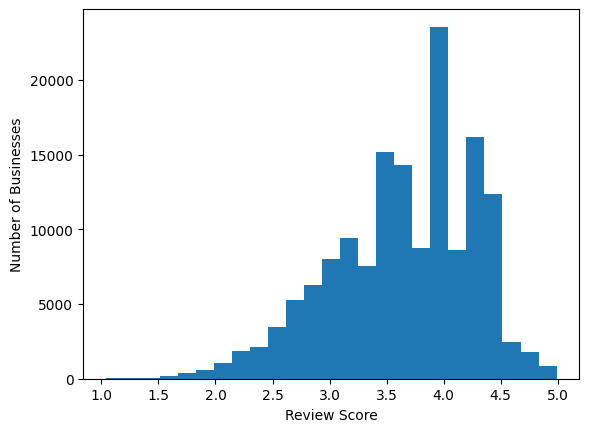

In [12]:
%matplotlib inline
# Bayesian Average for review score based on avg stars and review count
prior_stars = 3.75 # Average rating across all businesses in training
prior_conf = 8 # confidence, 25th percentile review count in training
def bayesian_review_score(avg_rating: float, review_count: int) -> float:
    """
    Calculate the Bayesian average rating.
    
    :param avg_rating: Average rating of the business.
    :param review_count: Number of reviews for the business.
    :param m: Minimum number of reviews to consider.
    :return: Bayesian average rating.
    """
    return (prior_stars*prior_conf + avg_rating*review_count) / (prior_conf + review_count)

yelp_df["ReviewScore"] = yelp_df.apply(lambda row: bayesian_review_score(row.stars, row.review_count), axis=1)

plt.hist(yelp_df["ReviewScore"], bins=25)
plt.xlabel("Review Score")
plt.ylabel("Number of Businesses")
plt.show()

The most important features are certain embeddings, which is perhaps not surprising due to the previously noted differences in typical reviews by industry/category. There are also several features which are essentially just ignored (feature importance < 1e-6).

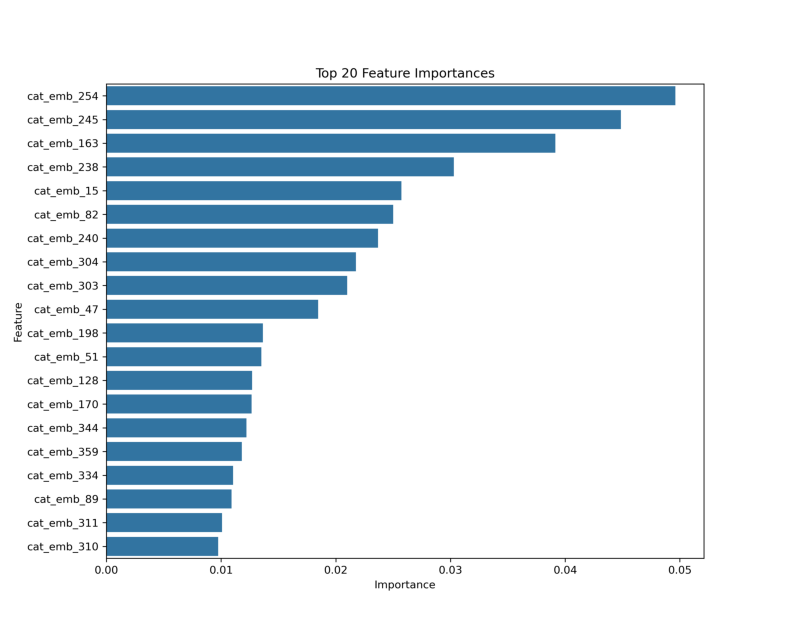

In [19]:
import matplotlib.image as mpimg
plt.figure(figsize=(10, 8))
plt.axis("off")
plt.imshow(mpimg.imread("./Data/Plots/feature_importance.png"))
plt.show()

Ignored Features:
- Count!!SEX AND AGE!!Total population
- Percent!!SEX AND AGE!!Total population!!35 to 39 years
- Percent!!SEX AND AGE!!Total population!!40 to 44 years
- Percent!!SEX AND AGE!!Total population!!60 to 64 years
- Percent!!SEX AND AGE!!Total population!!65 to 69 years
- Percent!!SEX AND AGE!!Total population!!80 to 84 years
- Percent!!RACE!!Total population!!One Race!!Native Hawaiian and Other Pacific Islander
- Percent!!HOUSEHOLDS BY TYPE!!Total households!!Married couple household
- Total Ignored Embeddings: 98

Some of the ignored features are likely due to redundancy. For example, all 3 of male, female, and total population were present in the data from the Census, meaning that total population could already be known by the model just from male and female populations. Similarly, there was other information about relationship status that could have made the percentage of household that are married couples unnecessary. Native Hawaiian and Pacific Islanders, since Hawaii was not included as a valid state in the dataset, were likely close to 0 for all locations, meaning that feature had minimal predictive power. The percentages of ages being ignored are harder to explain, but notably some age group information was indeed considered by the model. There were also 98 of the total 384 text embeddings that were ignored. This is likely due to the fact that a general purpose text embedding model was used on a domain specific, fairly small set of phrases, meaning that a significant amount of the information captured by the embedding would not differ among the data(and thus provide insights).

# 5) Final Thoughts/Next Steps

The moderate predictive accuracy of the model show that although there is some signal to be captured and insights to be drawn by considering how reviews are affected by business information and local demographics, there is quite a lot of noise and other factors remaining. This is not really surprising, one of the biggest components in a business' review score is simply the quality of its product and service, which is extremely difficult to quantify and certainly not easily able to be gathered for a large dataset. As such, a more useful metric may be "suitability", considering how well a certain business would match an area's demographics while accounting for variations in success due to business quality/operations and industry specific differences. This might be achieved by clustering, cosine similarity, or some other measure to group businesses, then using the predicted rating to find its quantile within that group.

In general, our dataset severely lacked variety of information, particularly about the specific businesses. Although some of this could be extracted from the attribute column, ideally information would be present for most or all of the businesses, and done with a standardized/objective metric. Although our model was fairly general purpose, it would likely be much more effective to specialize. For example, a restaurant-specific model may be able to much more accurately capture the impact of choices such as vegan menu offerings, whether alcohol is served, etc, compared to other restaurants other than completely unrelated businesses. It would also be ideal, though quite difficult, to consider more precise demographic data, accounting for factors such as tourism or the address surroundings.